In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Standard library imports
import datetime  # For handling date and time operations
import random  # For generating random numbers
import time  # For time-related functions like sleep and measuring execution time

# Third-party imports
import numpy as np  # Numerical operations and arrays
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Visualization library

# PyTorch imports for deep learning
import torch  # Main PyTorch library
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, TensorDataset  # Data handling for training

# Scikit-learn imports for machine learning tasks
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split  # Model selection and parameter tuning
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_absolute_error  # Evaluation metric

# TensorFlow and Keras imports for deep learning
import tensorflow as tf  # Main TensorFlow library
from tensorflow.keras import regularizers  # Regularization techniques
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed  # Keras layers for neural networks
from tensorflow.keras.models import Model  # Model class for building neural networks

In [3]:
seed = 29
torch.manual_seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
# Load your dataset
file_path = 'top10_hourly.csv'
data = pd.read_csv(file_path)

In [5]:
six_grids = (5059, 5159, 5262, 5061, 5259, 6064)
mask = data['gridID'].isin(six_grids)
data = data[mask]

In [6]:
data.head()

,gridID,startTime,smsIn,smsOut,callIn,callOut,internet
2976,5059,2013-11-01 00:00:00,177.102719,149.554856,92.687108,113.072191,3549.351436
2977,5059,2013-11-01 01:00:00,101.345768,159.323853,38.493504,56.650364,2511.210825
2978,5059,2013-11-01 02:00:00,56.312823,106.536970,31.904731,60.508954,2180.798190
2979,5059,2013-11-01 03:00:00,96.496178,102.286239,28.394988,104.482368,1857.653625
2980,5059,2013-11-01 04:00:00,94.968230,130.207161,14.962744,36.634123,2211.357051


In [7]:
# Convert startTime to datetime
data['startTime'] = pd.to_datetime(data['startTime'])

In [8]:
# Filter the data to keep only records on or before 2013-12-22
filtered_data = data[data['startTime'] <= '2013-12-22']

In [9]:
# Create anomaly marker columns for relevant features
filtered_data['anomaly'] = 0

In [10]:
# Splitting the dataset to train (80%) and test (20%)
# Sorting the data by 'startTime' to ensure the chronological order is maintained.                         ####

sorted_data = filtered_data.sort_values(by='startTime')

# Now, we calculate the index for the 80/20 split
split_index = int(len(sorted_data) * 0.8)

# Split the data into train and test sets
train_data = sorted_data.iloc[:split_index]
test_data = sorted_data.iloc[split_index:]

In [11]:
for grid in test_data['gridID'].unique():
    anomaly_mask_1 = (test_data['gridID'] == grid) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 18).date()) \
                 & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
    test_data.loc[anomaly_mask_1, 'smsIn'] *= 0.1  # Drop in SMS In
    test_data.loc[anomaly_mask_1, 'anomaly'] = 2  # Mark as smsIn anomaly

    anomaly_mask_2 = (test_data['gridID'] == grid) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 16).date()) \
                 & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
    test_data.loc[anomaly_mask_2, 'callOut'] *= 0.1  # Drop in Call Out
    test_data.loc[anomaly_mask_2, 'anomaly'] = 3  # Mark as callOut anomaly


anomaly_mask = (test_data['gridID'] == 5059) & (test_data['startTime'].dt.date == datetime.datetime(2013, 12, 14).date()) \
                 & (test_data['startTime'].dt.hour >= 10) & (test_data['startTime'].dt.hour <= 20)
test_data.loc[anomaly_mask, 'internet'] *= 2.5  # Spike in internet usage
test_data.loc[anomaly_mask, 'anomaly'] = 1  # Mark as internet anomaly

In [12]:
#save test dataset to CSV files
test_file_path = 'test_dataset_abnormal_lstm.csv'
test_data.to_csv(test_file_path, index=False)

In [13]:
# Set the startTime as the index
train_data.set_index('startTime', inplace=True)
test_data.set_index('startTime', inplace=True)

In [14]:
# Create time-based features
train_data['hour'] = train_data.index.hour
train_data['day_of_week'] = train_data.index.dayofweek
train_data['day_of_month'] = train_data.index.day
train_data['month'] = train_data.index.month

test_data['hour'] = test_data.index.hour
test_data['day_of_week'] = test_data.index.dayofweek
test_data['day_of_month'] = test_data.index.day
test_data['month'] = test_data.index.month

In [15]:
# Preserve the original gridID and timestamps for anomaly visualization
train_grid_ids = train_data['gridID'].values
test_grid_ids = test_data['gridID'].values
train_timestamps = train_data.index
test_timestamps = test_data.index

In [16]:
# Normalize/Standardize the data
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

In [17]:
# Drop gridID  and anomaly from the features for training and testing
train_data = train_data.drop(columns=['gridID'])
train_data = train_data.drop(columns=['anomaly'])
test_data = test_data.drop(columns=['gridID'])
test_data = test_data.drop(columns=['anomaly'])

In [18]:
# reshape inputs for LSTM [samples, timesteps, features]
train_data = train_data.values.reshape(train_data.shape[0], 1, train_data.shape[1])
print("Training data shape:", train_data.shape)
test_data = test_data.values.reshape(test_data.shape[0], 1, test_data.shape[1])
print("Test data shape:", train_data.shape)

Training data shape: (5880, 1, 9)
Test data shape: (5880, 1, 9)


In [19]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [20]:
# create the autoencoder model
model = autoencoder_model(train_data)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 9)           │           153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,641 (14.22 KB)

 Trainable params: 3,641 (14.22 KB)

 Non-trainable params: 0 (0.00 B)

187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.9547 - val_loss: 0.6400
Time for epoch 1: 11.80 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4593 - val_loss: 0.5402
Time for epoch 2: 1.37 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3903 - val_loss: 0.5147
Time for epoch 3: 1.35 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3459 - val_loss: 0.4331
Time for epoch 4: 2.62 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2749 - val_loss: 0.3242
Time for epoch 5: 2.62 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2059 - val_loss: 0.2761
Time for epoch 6: 1.70 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1735 - val_loss: 0.2601
Time for epoch 7: 2.65 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1578 - val_loss: 0.2559
Time for epoch 8: 1.34 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1481 - val_loss: 0.2496
Time for epoch 9: 1.32 seconds
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

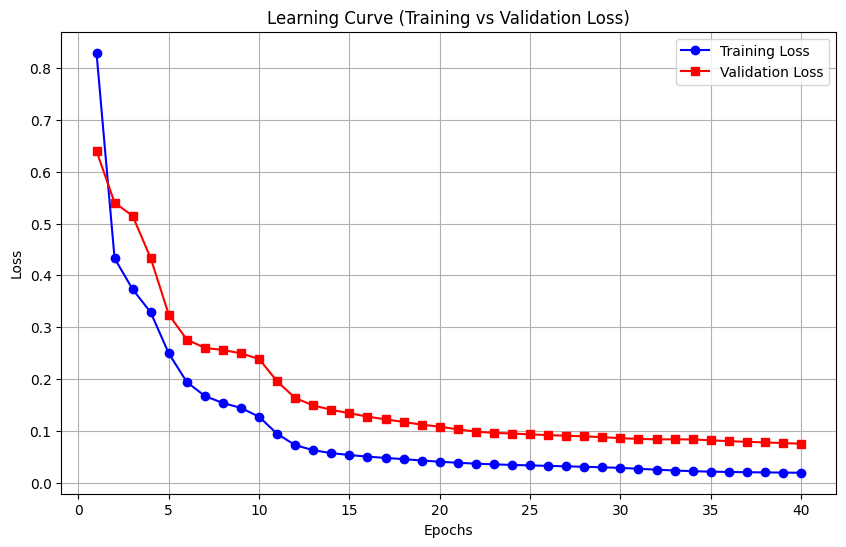

In [21]:
# fit the model to the data
# Set parameters
nb_epochs = 40
batch_size = 30

# Track training time
start_time = time.time()

# Store loss and validation loss for plotting
train_loss = []
val_loss = []

# Track time per epoch
epoch_times = []

# Train the model and time each epoch
for epoch in range(nb_epochs):
    epoch_start = time.time()

    history = model.fit(train_data, train_data, epochs=1, batch_size=batch_size, validation_split=0.05, verbose=1).history

    # Append the loss and validation loss
    train_loss.append(history['loss'][0])
    val_loss.append(history['val_loss'][0])

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    epoch_times.append(epoch_time)
    print(f"Time for epoch {epoch + 1}: {epoch_time:.2f} seconds")

# Calculate total training time
end_time = time.time()
total_time = end_time - start_time

print(f"Total training time: {total_time:.2f} seconds")
print(f"Average time per epoch: {sum(epoch_times) / nb_epochs:.2f} seconds")

# Plot the learning curve (training and validation loss)
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss', color='blue', marker = 'o')
plt.plot(range(1, nb_epochs + 1), val_loss, label='Validation Loss', color='red', marker = 's')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Training vs Validation Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Reconstruct signals and calculate losses
reconstructed_signals = model.predict(test_data)
losses = tf.keras.losses.MSE(test_data, reconstructed_signals)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [23]:
test_data.shape

(1470, 1, 9)

In [24]:
reconstructed_signals.shape

(1470, 1, 9)

In [25]:
anomalies = losses

In [26]:
anomalies.shape

TensorShape([1470, 1])

In [27]:
#reshape anomalies
anomalies = tf.reshape(anomalies, (anomalies.shape[0],))

In [28]:
#reshape outputs
reconstructed_signals = reconstructed_signals.reshape(reconstructed_signals.shape[0], reconstructed_signals.shape[2])
test_data = test_data.reshape(test_data.shape[0], test_data.shape[2])

In [29]:
def plot_reconstruction_for_grid_id(grid_id, original_data, reconstructed_data, timestamps):
    fig, axs = plt.subplots(5, 1, figsize=(14, 20))
    columns = ['smsIn', 'smsOut', 'callIn', 'callOut', 'internet']
    font_title = 20
    font_label = 20
    font_legend = 13

    grid_mask = test_grid_ids == grid_id
    for i, column in enumerate(columns):
        indices = [j for j, x in enumerate(grid_mask) if x]
        axs[i].plot([timestamps[j] for j in indices], original_data[grid_mask, i], label='Original')
        axs[i].plot([timestamps[j] for j in indices], reconstructed_data[grid_mask, i], label='Reconstructed')
        axs[i].set_title(f'{column} - Original vs Reconstructed for GridID {grid_id}', fontsize=font_title)
        axs[i].legend(fontsize=font_legend)
        axs[i].set_xlabel('Time', fontsize=font_label)
        axs[i].set_ylabel(column, fontsize=font_label)
        axs[i].tick_params(axis='both', labelsize=font_label)

    plt.tight_layout()
    plt.show()

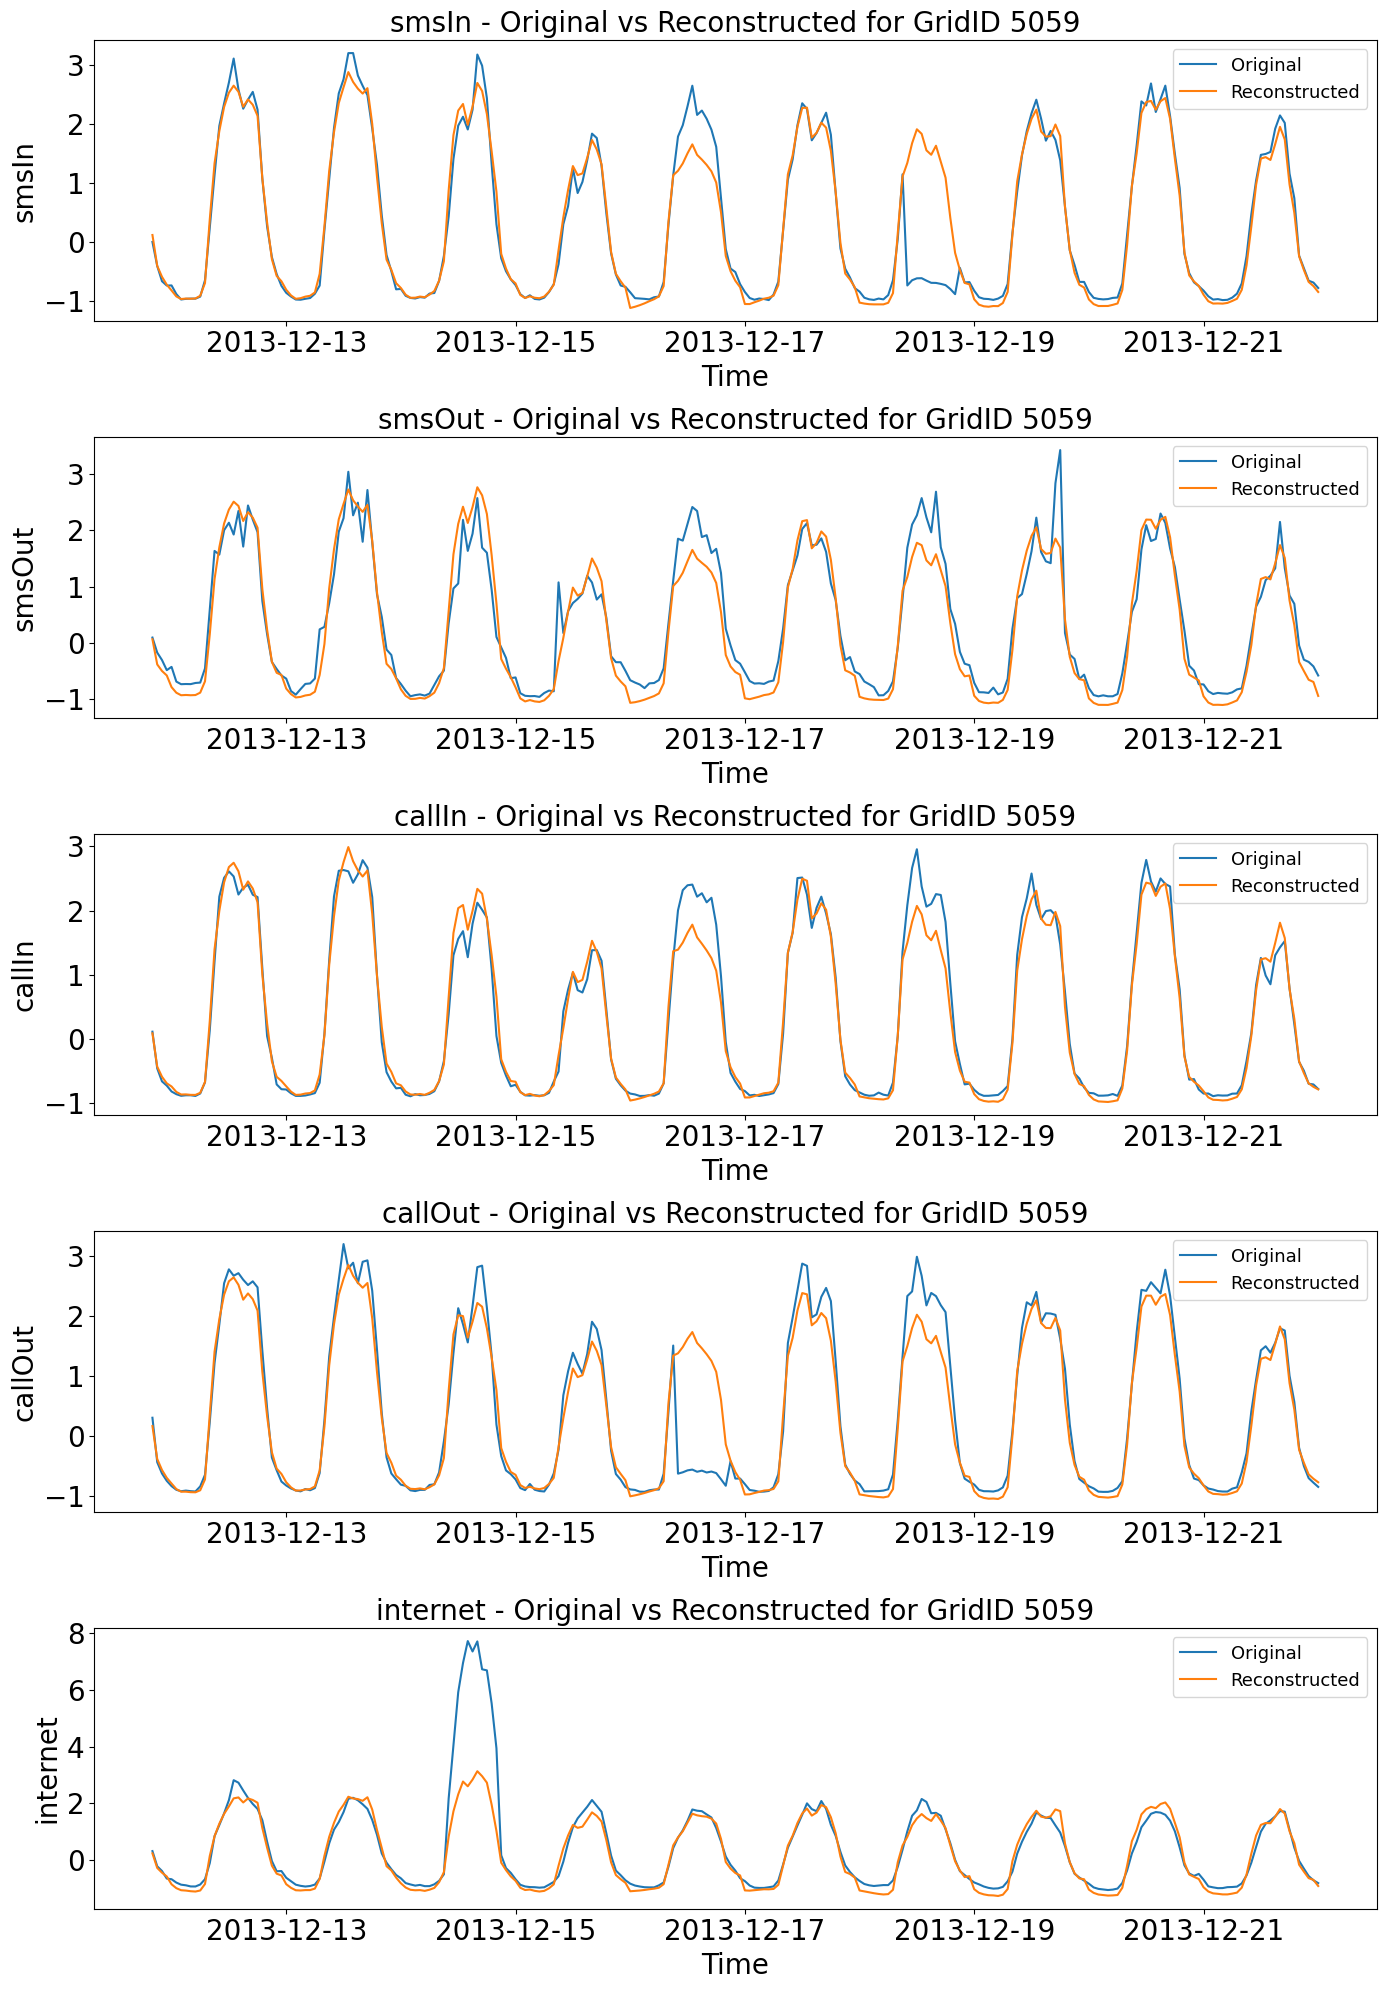

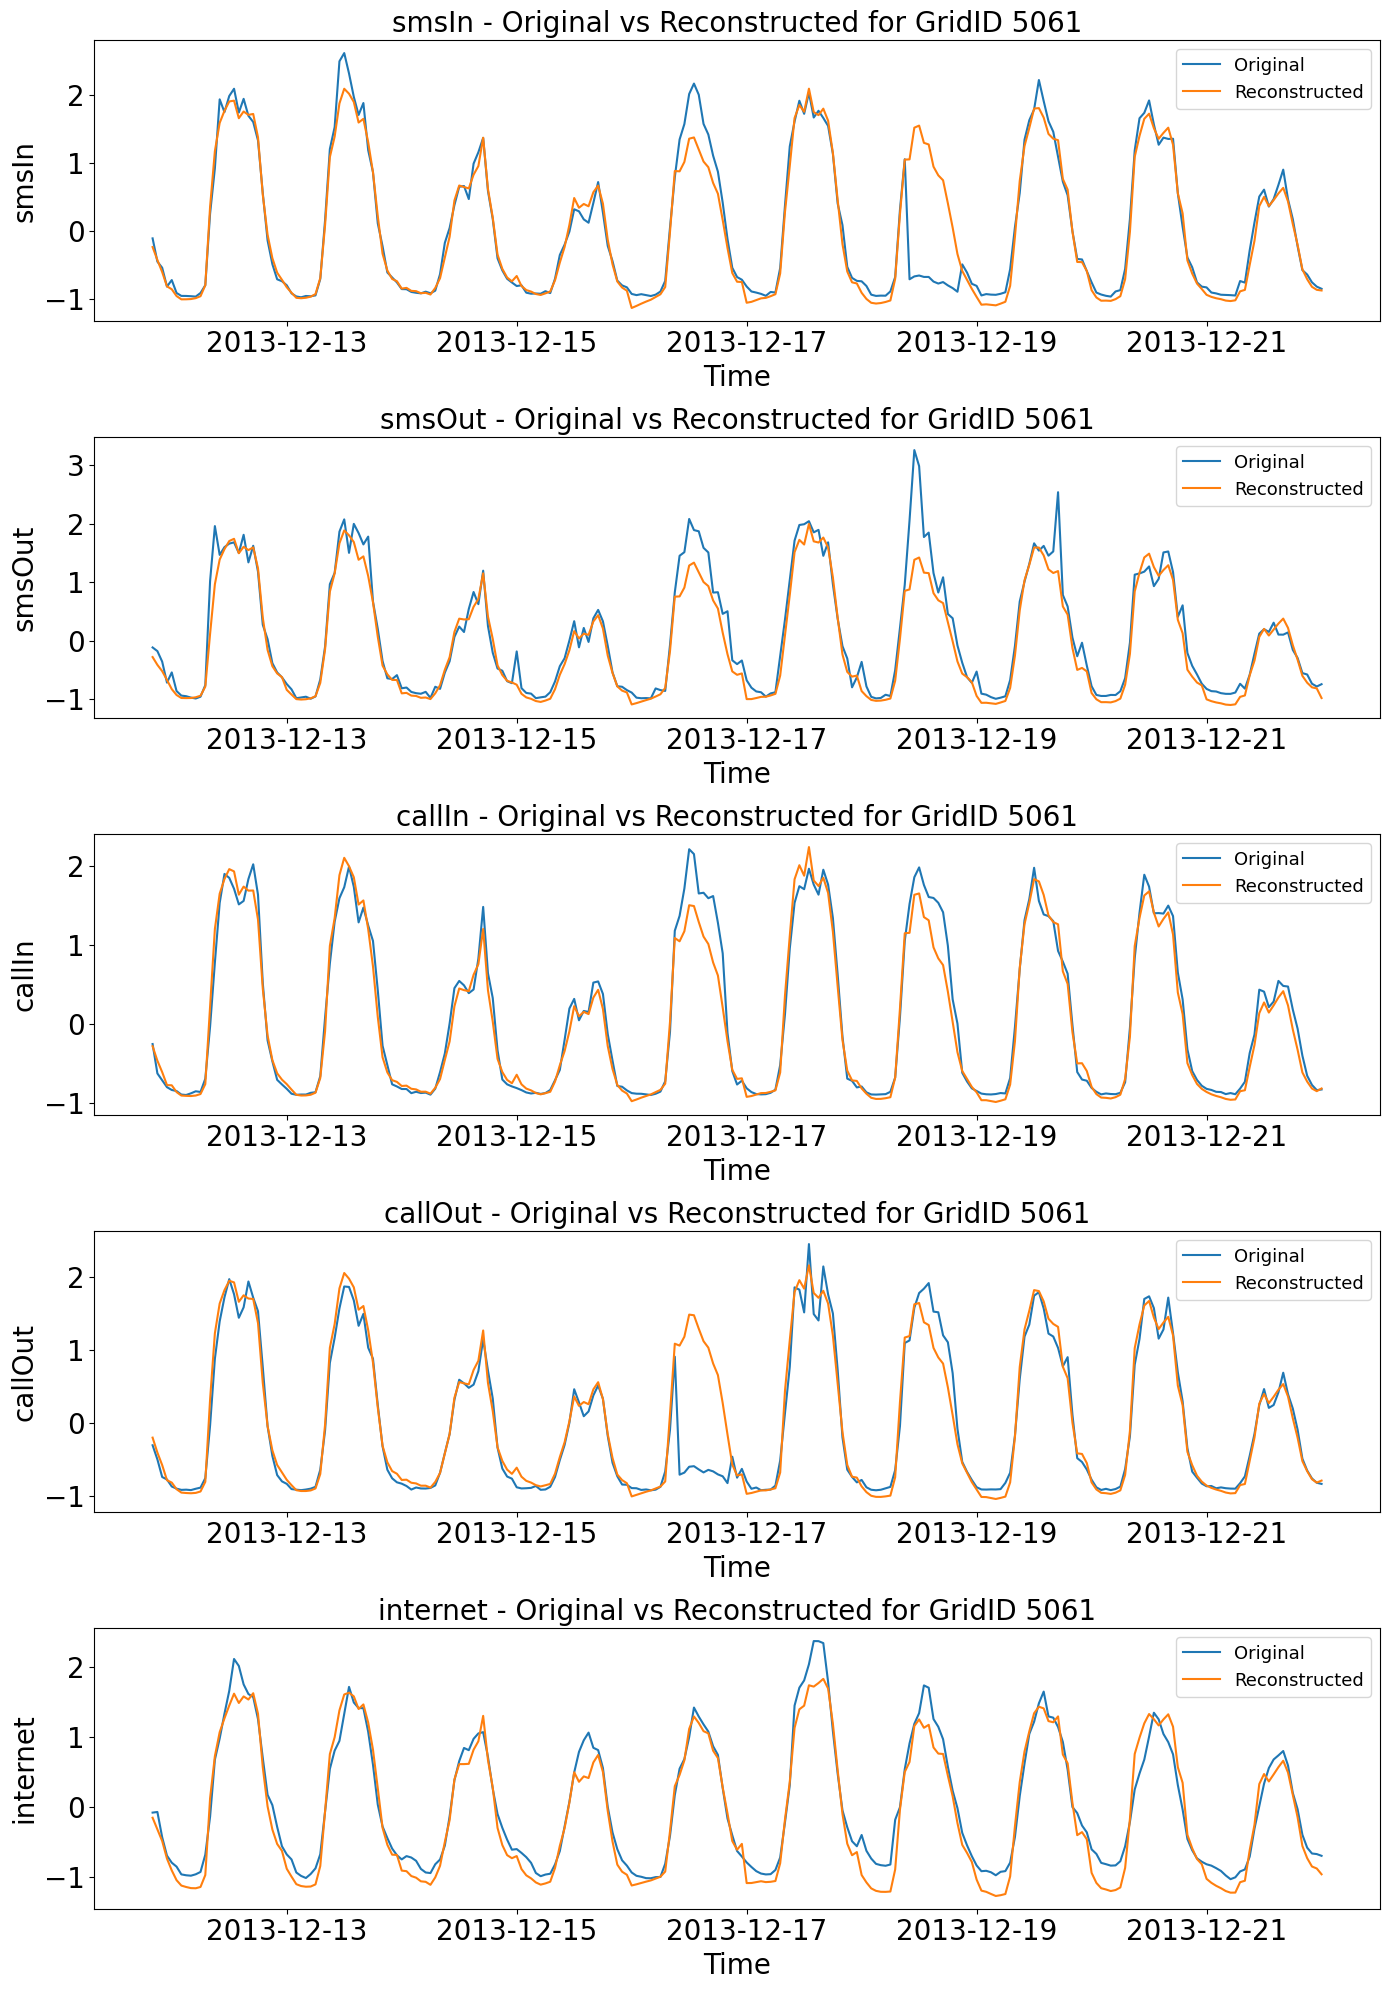

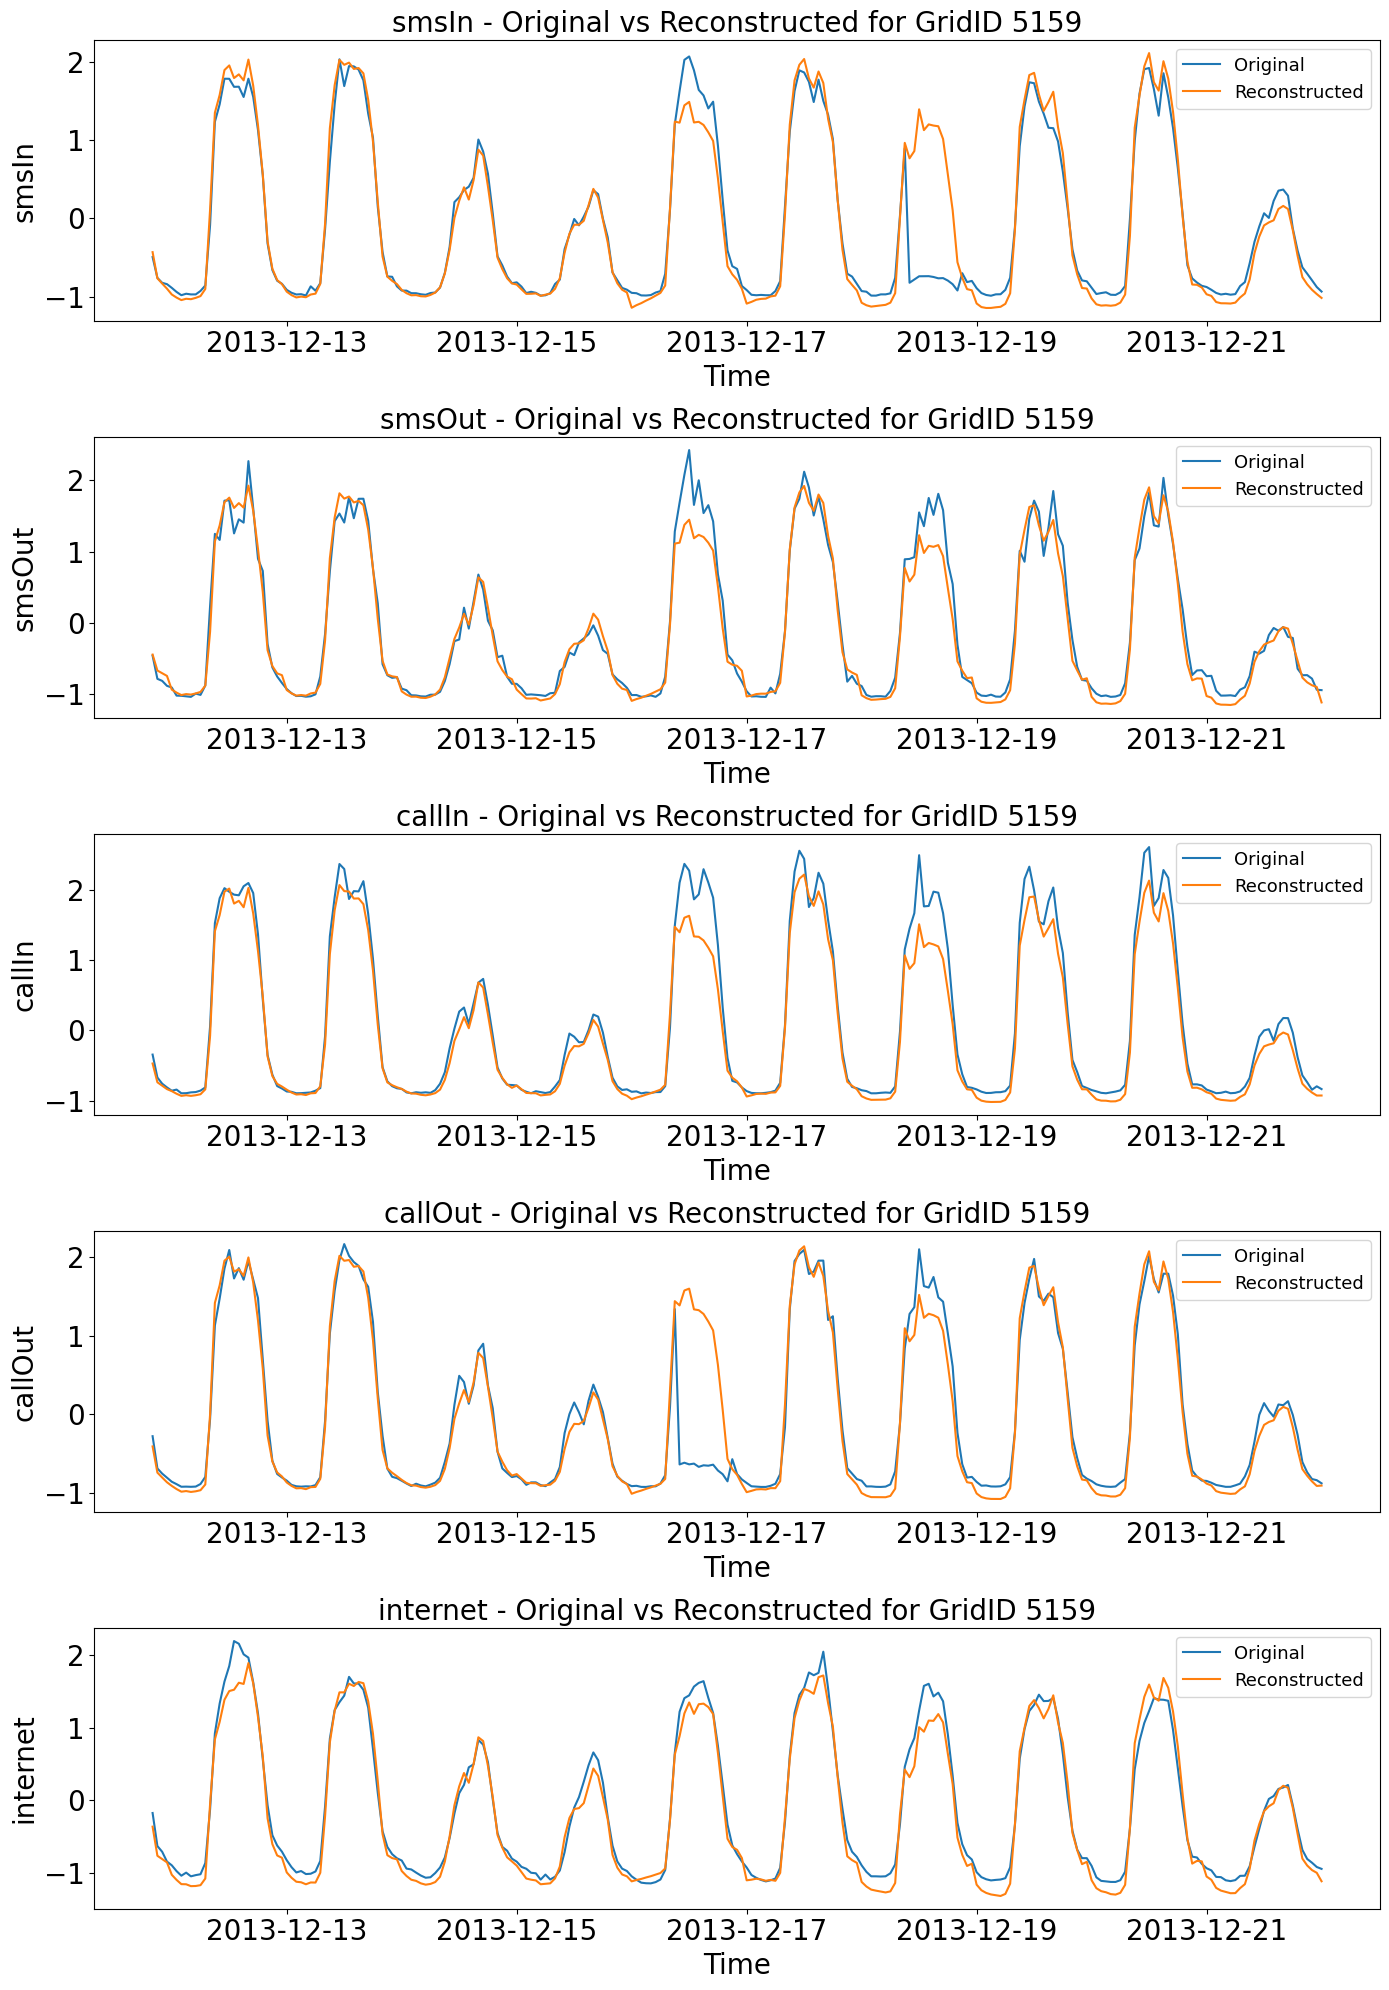

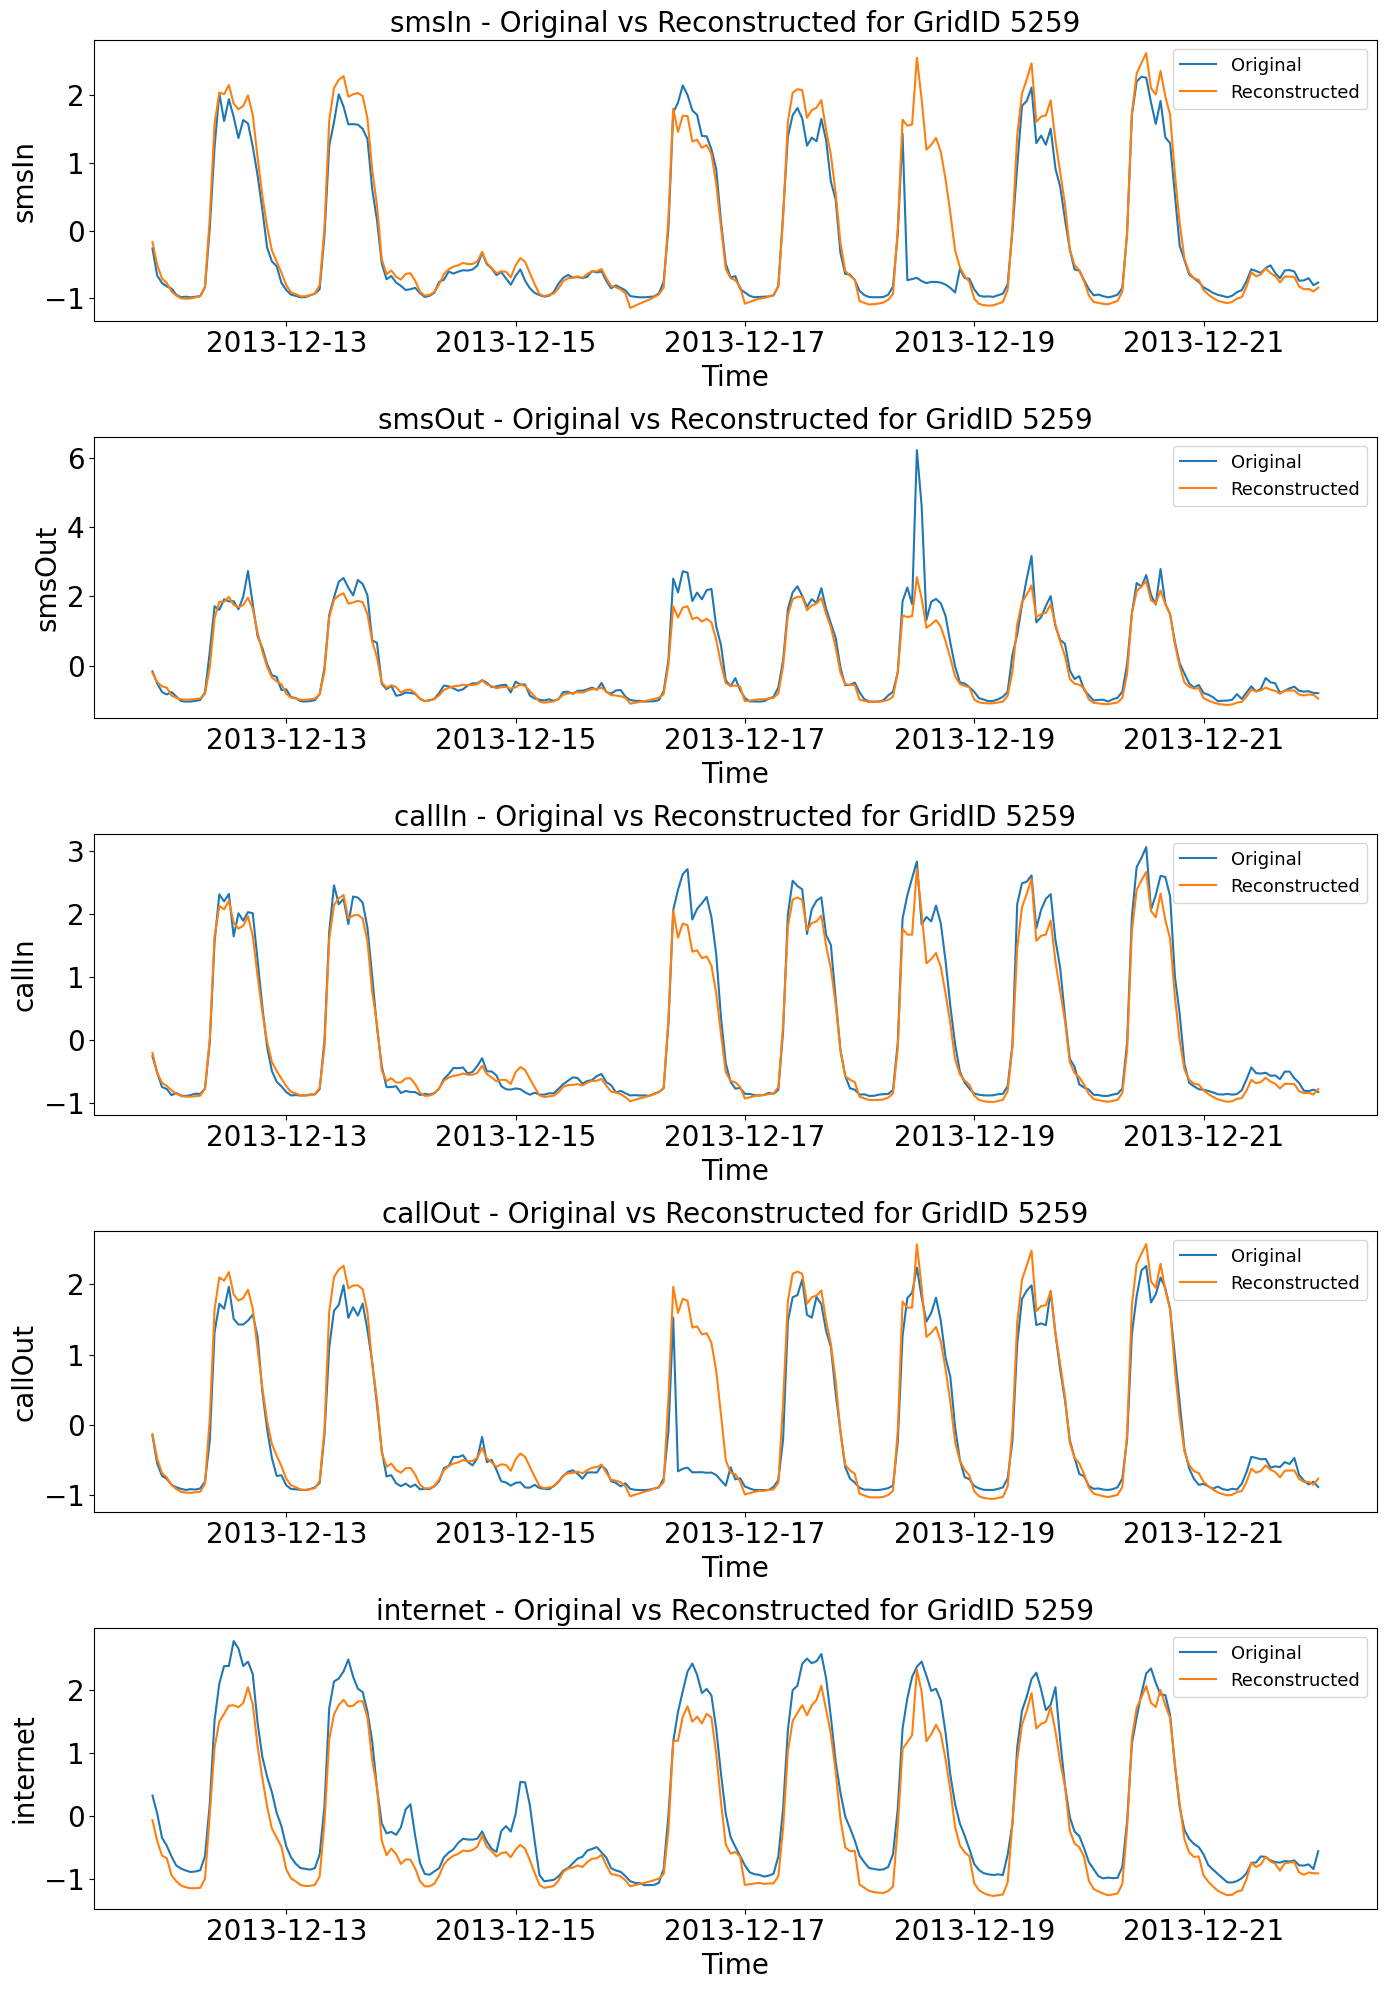

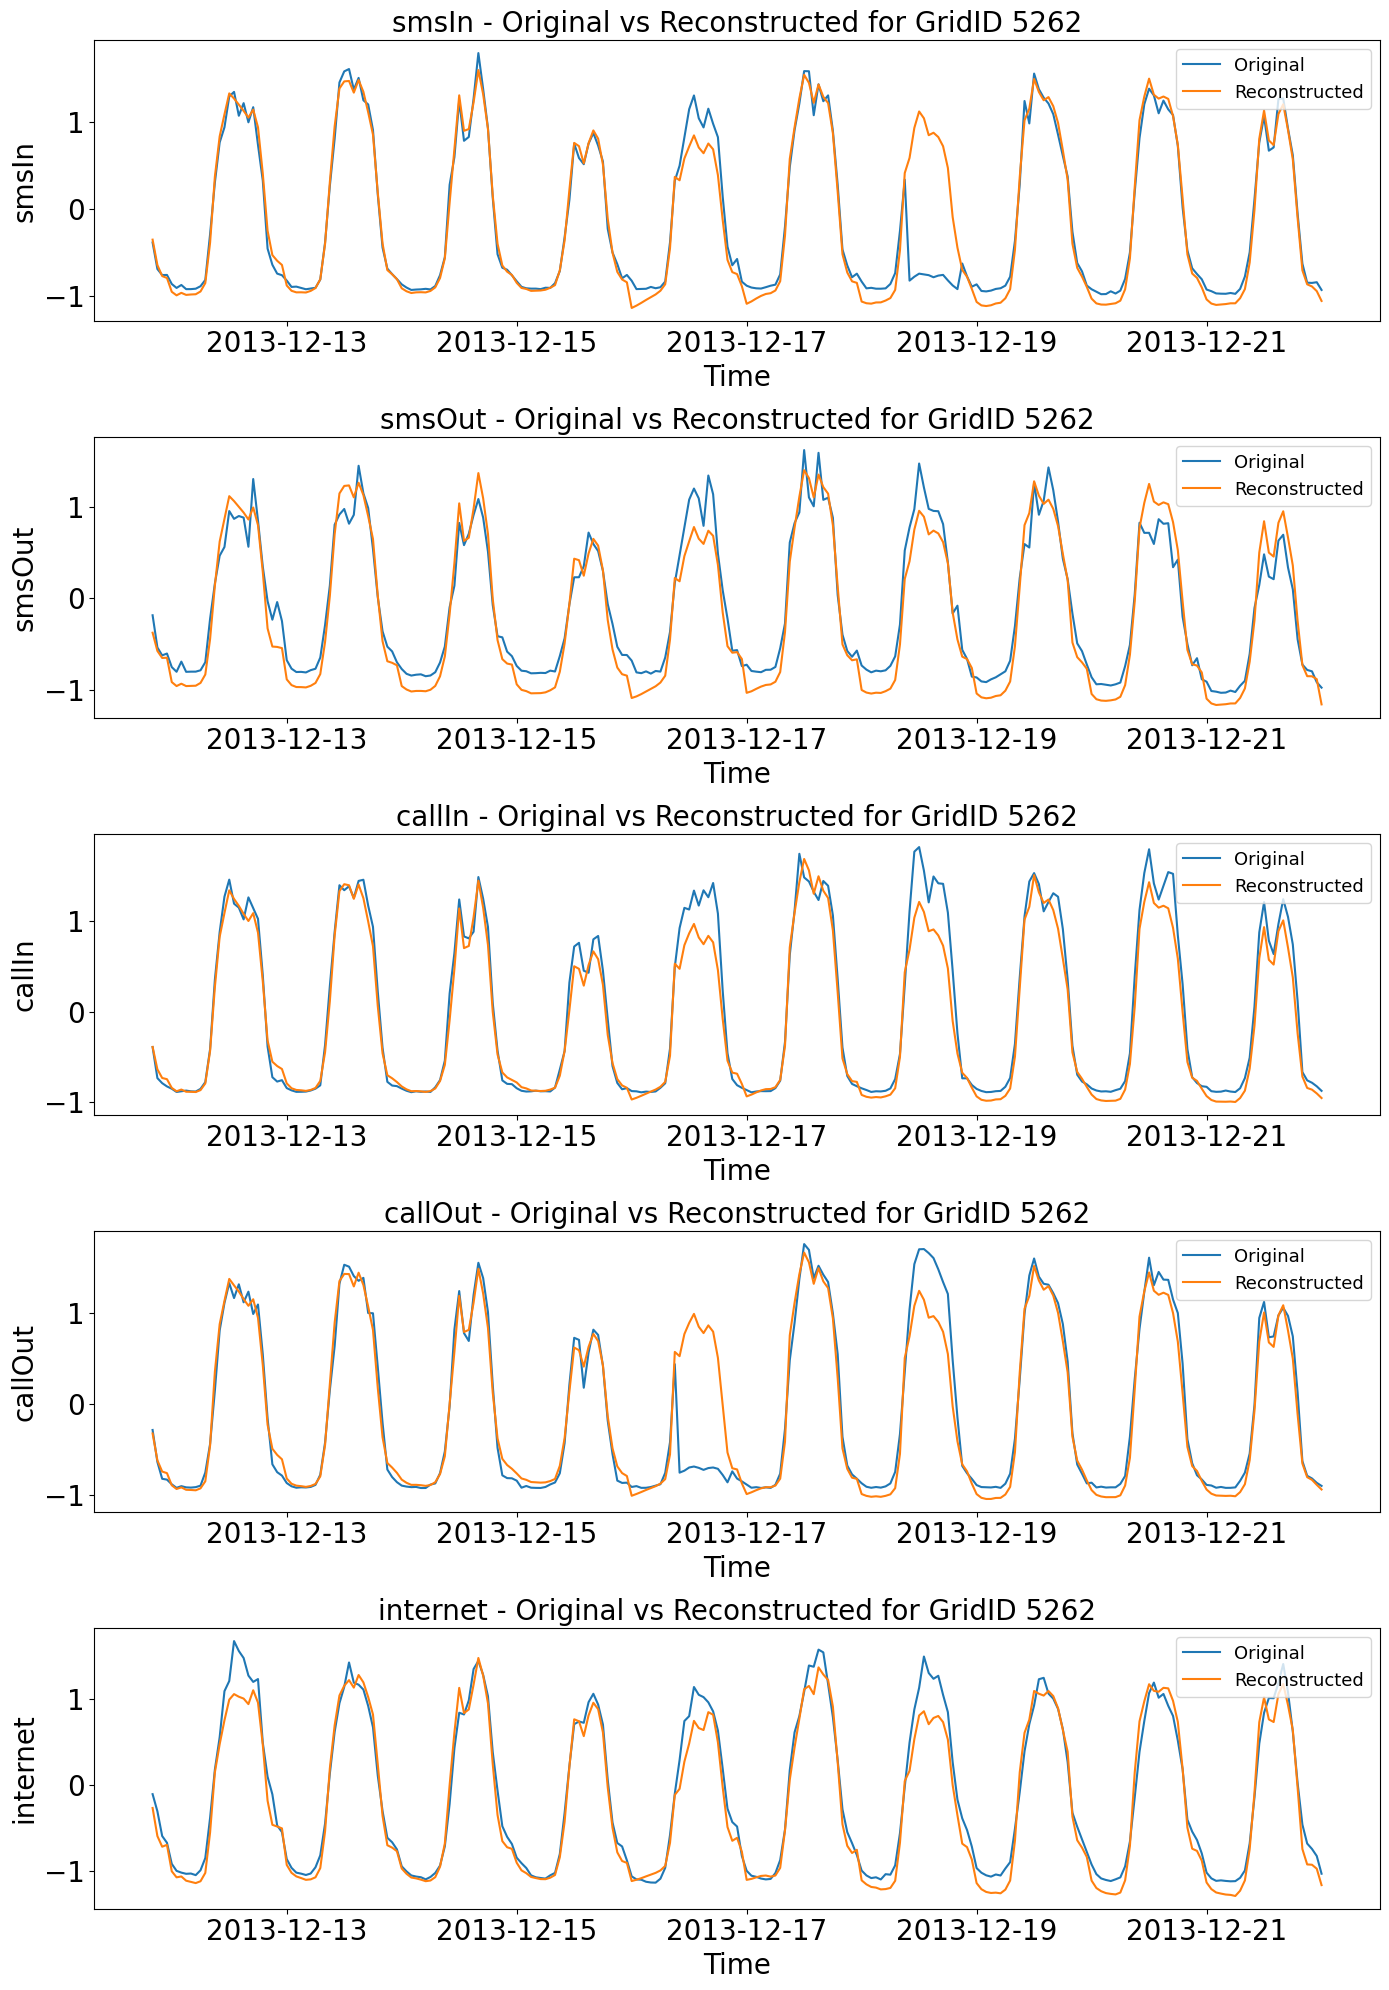

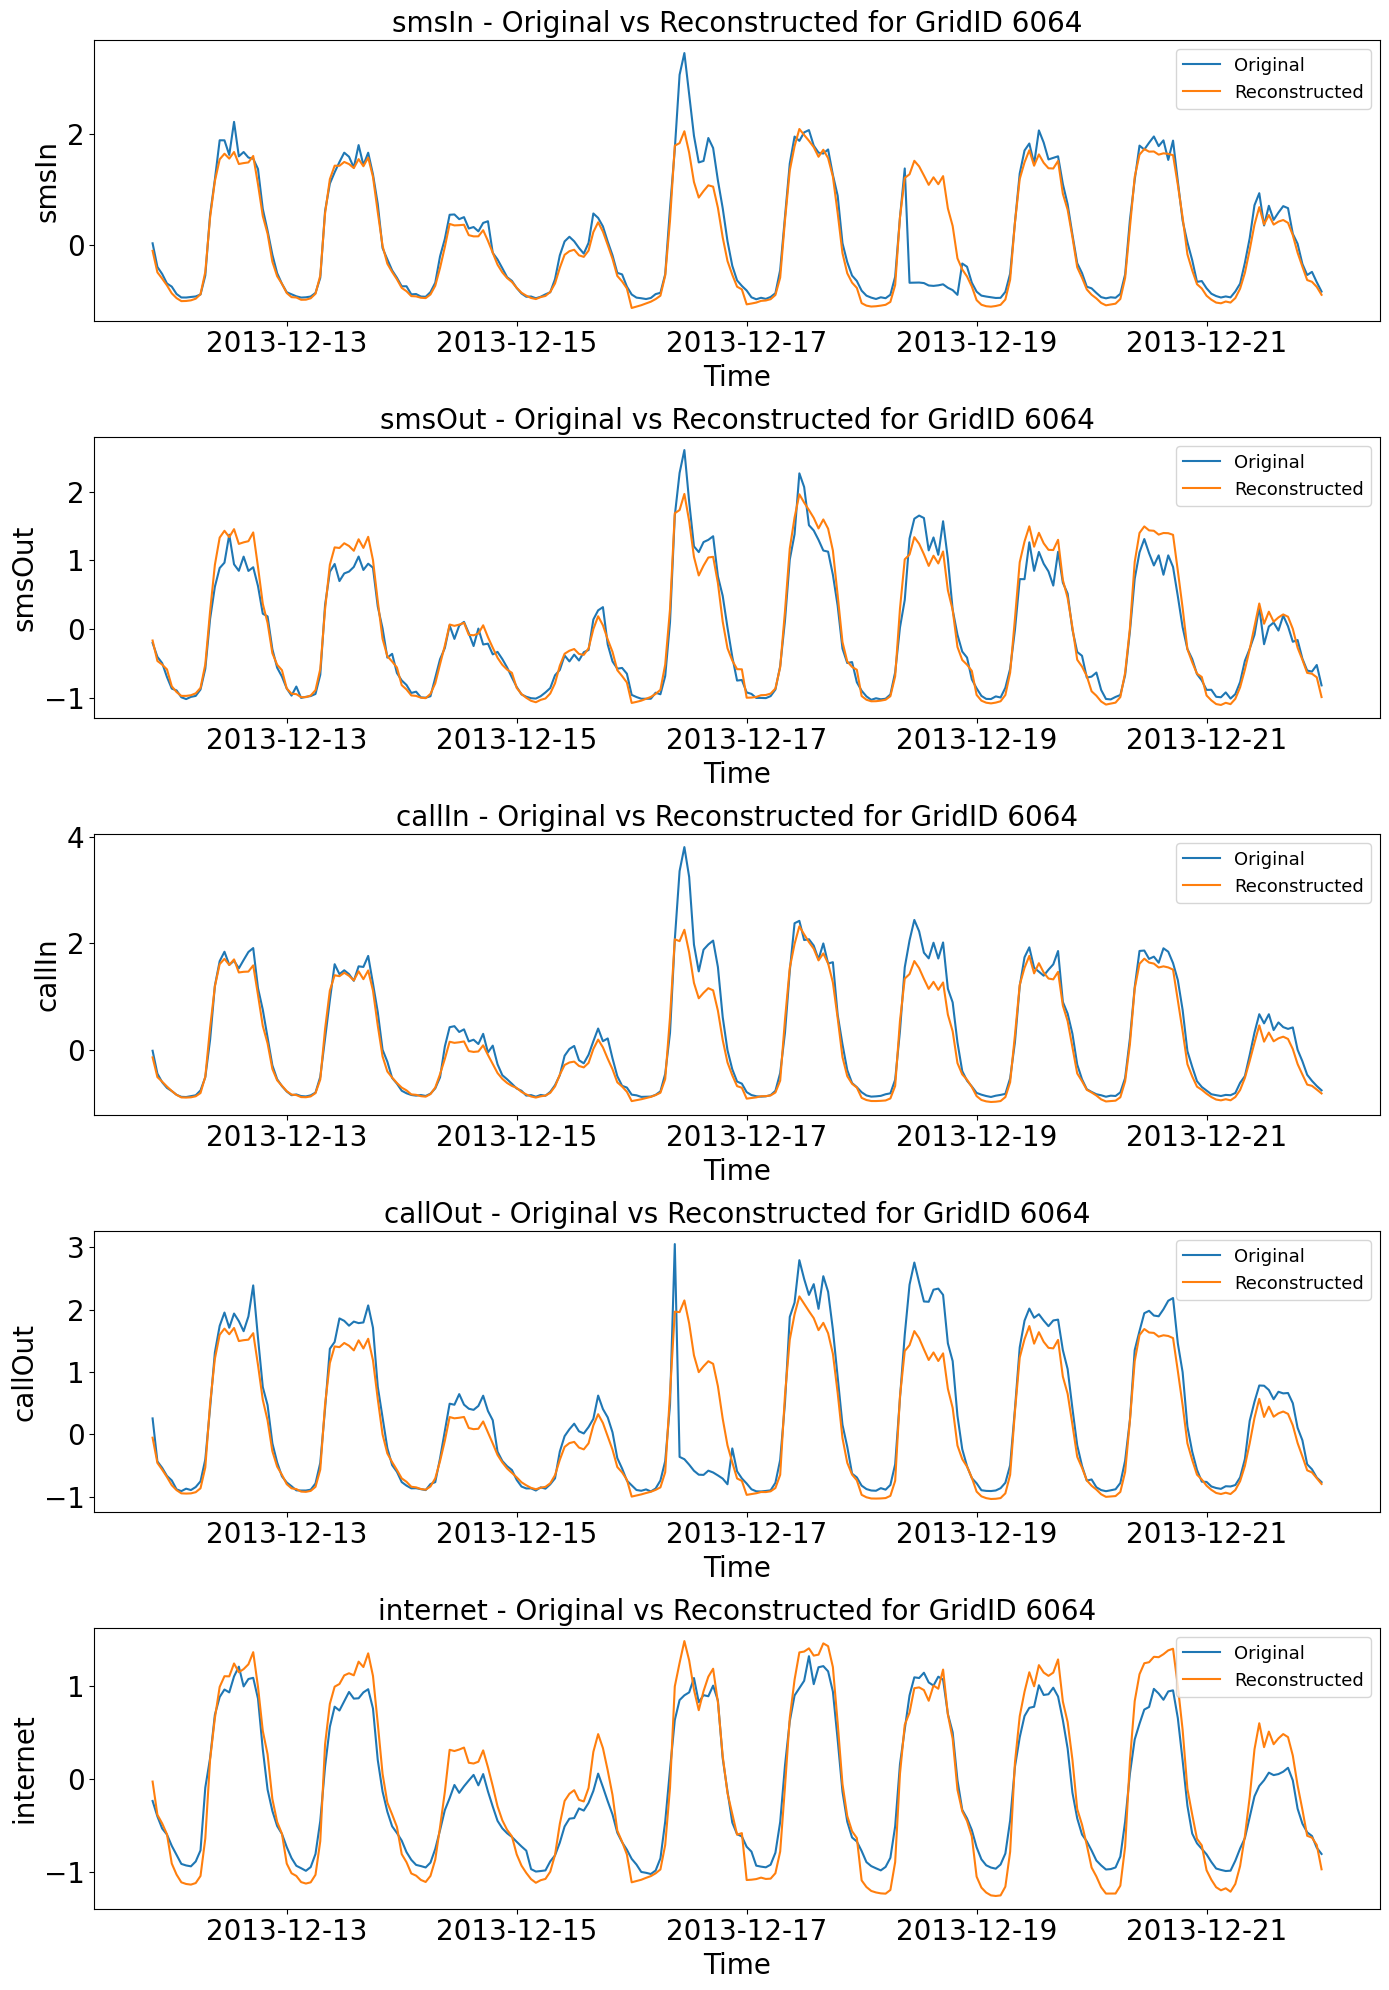

In [30]:
# Plot original vs reconstructed data for each unique gridID in the test set
unique_grid_ids = np.unique(test_grid_ids)
for grid_id in unique_grid_ids:
    plot_reconstruction_for_grid_id(grid_id, test_data, reconstructed_signals, test_timestamps)

In [31]:
anomalies = anomalies.numpy()

In [32]:

def identify_anomalies(anomalies, test_timestamps, test_grid_ids, test_data):
    # Ensure 'anomalies' is of numeric type
    anomalies = anomalies.astype(float)  # Convert to float if it's not already
    anomaly_threshold = np.percentile(anomalies, 80)
    anomaly_indices = np.where(anomalies > anomaly_threshold)[0]
    anomaly_indices = anomaly_indices.astype(int).tolist()
    anomaly_timestamps = [test_timestamps[i] for i in anomaly_indices]
    anomaly_grid_ids = test_grid_ids[anomaly_indices]
    return anomaly_timestamps, anomaly_grid_ids, anomaly_threshold, anomaly_indices


In [33]:
def plot_anomalies(test_timestamps, anomalies, anomaly_threshold,anomaly_timestamps, anomaly_grid_ids, anomaly_indices):
  # Visualize anomalies
  plt.figure(figsize=(14, 7))
  plt.plot(test_timestamps, anomalies, label='Anomaly Score')
  plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
  plt.scatter(anomaly_timestamps, anomalies[anomaly_indices], color='red', label='Anomalies')
  plt.xlabel('Time')
  plt.ylabel('Anomaly Score')
  plt.title('Anomaly Detection in Mobile Network Data')
  plt.legend()
  plt.show()

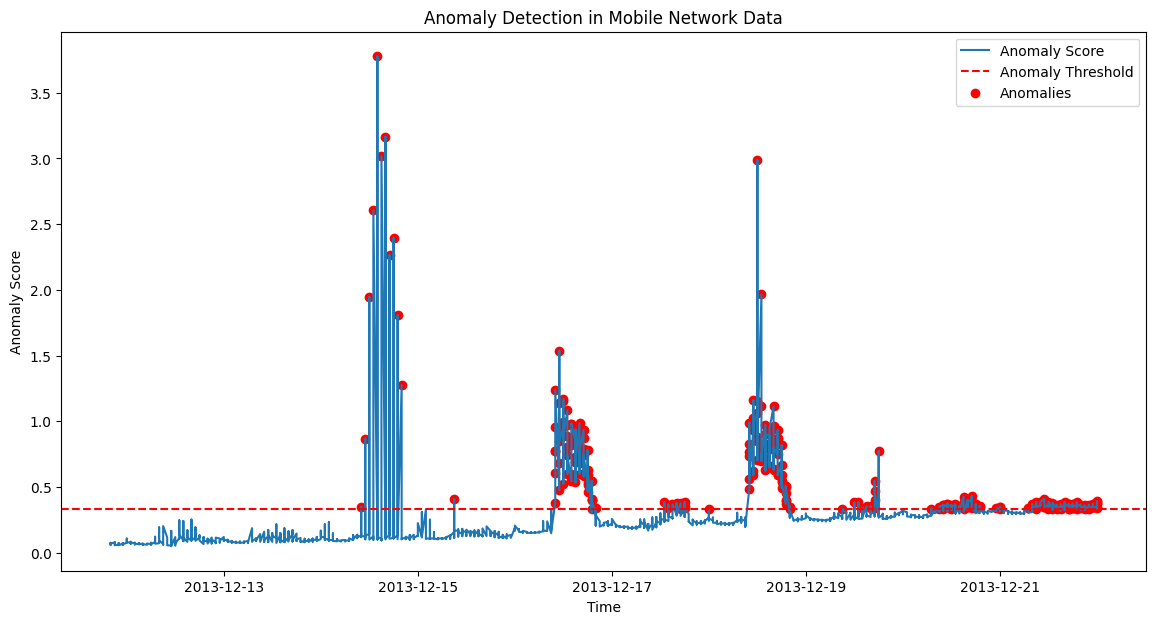

In [34]:
anomaly_timestamps, anomaly_grid_ids, anomaly_threshold, anomaly_indices = identify_anomalies(anomalies, test_timestamps, test_grid_ids, test_data)
#
anomalous_data_model = pd.DataFrame()
anomalous_data_model['anomaly_timestamp'] = anomaly_timestamps
anomalous_data_model['anomaly_timestamp'] = pd.to_datetime(anomalous_data_model['anomaly_timestamp'], format="%Y-%m-%d %H:%M:%S")
anomalous_data_model['anomaly_grid'] = anomaly_grid_ids
anomalous_data_model.to_csv('anomalies_model.csv', index=False)
#
plot_anomalies(test_timestamps, anomalies, anomaly_threshold, anomaly_timestamps, anomaly_grid_ids, anomaly_indices)

In [35]:
#Drop all anomaly columns equal to 0
test_abnormal = pd.read_csv("/content/test_dataset_abnormal_lstm.csv")
test_abnormal = test_abnormal[test_abnormal["anomaly"] != 0]
test_abnormal.to_csv("filtered_test_dataset_abnormal.csv", index=False)

In [36]:
#anomalous_data_model => anomalies identified by the model     (anomalies_model)
#test_abnormal => injected anomalies (true anomalies)          (filtered_test_dataset_abnormal)

# Convert 'Timestamp' and 'startTime' using automatic format inference
anomalous_data_model['anomaly_timestamp'] = pd.to_datetime(anomalous_data_model['anomaly_timestamp'], errors='coerce')
test_abnormal['startTime'] = pd.to_datetime(test_abnormal['startTime'], errors='coerce')

In [37]:
anomalous_data_model.shape

(294, 2)

In [38]:
len(anomalies)

1470

In [39]:
try:
    anomalous_data_model['anomaly_timestamp'] = pd.to_datetime(anomalous_data_model['anomaly_timestamp'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    test_abnormal['startTime'] = pd.to_datetime(test_abnormal['startTime'], format='%Y-%m-%d %H:%M:%S', errors='raise')
except ValueError:
    # If the above format fails, try a different format or investigate the data
    # You can print some values of the columns to understand the format
    print("Error converting with '%Y-%m-%d %H:%M:%S' format. Check data format.")
    print("Example values from anomalous_data_model['anomaly_timestamp']:", anomalous_data_model['anomaly_timestamp'].head())
    print("Example values from test_abnormal['startTime']:", test_abnormal['startTime'].head())
    # Add further error handling or format specifications here

In [40]:
# Merge the two dataframes on matching GridID and Timestamp/startTime
merged_df = pd.merge(anomalous_data_model, test_abnormal, left_on=['anomaly_timestamp', 'anomaly_grid'], right_on=['startTime', 'gridID'], how='inner')

In [42]:
#Anomalies found
print(f"{merged_df.shape[0]} / {test_abnormal.shape[0]}")

133 / 143
